In [1]:
from dotenv import load_dotenv
load_dotenv("../config.env")

True

In [3]:
from coamp_graph import Graph
import coamp_graph_notebook_utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
coamp_graph_notebook_utils.get_all_projects()

['CCLE',
 'COLO320',
 'COLO320 DM & HSR hg38',
 'COLOtest',
 'GBM39',
 'PCAWG',
 'TCGA']

In [5]:
coamp_graph_notebook_utils.get_all_alias()

['655bda68bba7c92509522479',
 '655c060abba7c925095555da',
 'COLO320',
 'COLO320_1',
 'GBM39',
 'ccle',
 'coolest']

In [6]:
project_list = ['655bda68bba7c92509522479', '655c060abba7c925095555da', 'ccle']
df, __ = coamp_graph_notebook_utils.concat_projects(project_list)

In [7]:
df.shape

(5448, 25)

In [ ]:
graph = Graph(df)
nodes = graph.Nodes()
edges = graph.Edges()

In [ ]:
graph.genes_with_no_chr_match_list

In [ ]:
edges[0]

In [ ]:
# P-value/Q-value Distributions by Test Type

In [ ]:
p_single, p_multi_interval, p_multi_chr, p_multi_ecdna = [], [], [], []
q_single, q_multi_interval, q_multi_chr, q_multi_ecdna = [], [], [], []
na_counter = 0
for edge in edges:
    p_vals = edge.get('p_values', [-1, -1, -1, -1])
    q_vals = edge.get('q_values', [-1, -1, -1, -1])
    if p_vals == [-1, -1, -1, -1]:# and edge.get('missing_interval_data'):
        na_counter += 1
    if len(p_vals) == 4:
        p_single.append(p_vals[0])
        p_multi_interval.append(p_vals[1])
        p_multi_chr.append(p_vals[2])
        p_multi_ecdna.append(p_vals[3])
    if len(q_vals) == 4:
        q_single.append(q_vals[0])
        q_multi_interval.append(q_vals[1])
        q_multi_chr.append(q_vals[2])
        q_multi_ecdna.append(q_vals[3])
na_counter

In [ ]:
def every_fifth_percentile(data):
    data = np.array(data)
    percentiles = np.arange(5, 100, 5)
    return {p: np.percentile(data, p) for p in percentiles}

# Calculate the percentiles and format them
def print_percentiles_aligned(data):
    results = every_fifth_percentile(data)

    # Format and find max width for alignment
    formatted = {k: f"{v:.4f}" for k, v in results.items()}
    max_width = max(len(val) for val in formatted.values())

    for k in sorted(formatted):
        print(f"{k:>2}th percentile: {formatted[k]:>{max_width}}")

In [ ]:
def plot_p_values(p_values, title="p_values"):
    filtered = [p for p in p_values if p != -1]
    print(f"{len(filtered)} valid p-values from {len(p_values)} edges\n")
    
    print_percentiles_aligned(filtered)
    
    plt.figure(figsize=(8, 6))
    plt.hist(filtered, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("p-values")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    


In [ ]:
plot_p_values(p_single, title=f"Single Interval P-Values (T1)")

In [ ]:
plot_p_values(q_single, title=f"Single Interval Q-Values (T1)")

In [ ]:
plot_p_values(p_multi_interval, title=f"Multi Interval P-Values (T2)")

In [ ]:
plot_p_values(q_multi_interval, title=f"Multi Interval Q-Values (T2)")

In [ ]:
# PARAMETER SWEEP FOR MERGING THRESHOLD

In [ ]:
# test merge cutoff param
project_list_small = ['COLO320', 'GBM39']
test_df, __ = coamp_graph_notebook_utils.concat_projects(project_list_small)
test_graph = Graph(test_df, merge_cutoff=50000)
print(test_graph.MERGE_CUTOFF)

In [ ]:
tmp_graph = Graph(test_df, merge_cutoff=50000, construct_graph=False)
processed_dataset = tmp_graph.preprocessed_dataset

In [ ]:
def plot_lengths_dist(lengths, ax, merge_cutoff):
    # add a subplot
    ax.hist(lengths, bins=50, alpha=0.7, color='blue')
    ax.set_title(f'merge_cutoff = {merge_cutoff}bp')
    ax.set_xlabel(f"Interval Lengths (n={len(lengths)})")
    ax.set_ylabel("Frequency")

    # plot mean line
    if lengths:
        adj_mean = sum(lengths) / len(lengths)
        ax.axvline(adj_mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean = {adj_mean:.2f}')
    ax.legend()

In [ ]:
cutoff_values = list(range(10000, 51000, 5000))
num_plots = len(cutoff_values)
cols = 4
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten() 

for idx, merge_cutoff in enumerate(cutoff_values):
    ax = axes[idx]

    tmp_graph = Graph(df, merge_cutoff=merge_cutoff, construct_graph=False)
    processed_dataset = tmp_graph.preprocessed_dataset
    lengths = [interval[2] - interval[1] for list in processed_dataset['Merged_Intervals'] for interval in list if interval]

    plot_lengths_dist(lengths, ax, merge_cutoff)

# hide unused subplots if any
for j in range(len(cutoff_values), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [8]:
### PLOT pdD DISTRIBUTION FOR CAPPED LENGTHS MODEL ###

In [9]:
# df, __ = coamp_graph_notebook_utils.concat_projects(project_list)

In [10]:
baseline = Graph(df)
capped = Graph(df, pdD_model='gamma_capped_5m')

Retrieved locations for 22998 GRCh38 genes in 0.07 seconds
Loaded 28555 genes from provided reference files
Gene record creation time: 1.73 seconds
31508
Matched location data for 22976 genes
Filtering features took 0.0045 seconds, resulting in 1119 features
Preprocessing intervals and reformatting dataset took 0.0447 seconds
Starting CreateNodes with 1119 rows
Note: 26 genes are amplified on multiple feature IDs in the same sample
TEST: 18469 searches where gene's location is found
TEST: 13798 searches where gene's chr on interval and gene's location is matched to an interval
TEST: 4660 searches where gene's chr on interval but gene's location is NOT matched to an interval (2457 unique nodes)
TEST: 11 searches where gene's chr not on interval (7 unique nodes)
Processing 18587 genes took 0.0751 seconds, resulting in 7832 unique nodes
0 genes were not amplified on any merged intervals
Total CreateNodes execution: 0.0762 seconds
Starting CreateEdges with 7832 nodes
Building features inde

In [13]:
pdD_baseline = [edge['p_d_D'] for edge in baseline.Edges() if edge['p_d_D'] != -1]
pdD_capped = [edge['p_d_D'] for edge in capped.Edges() if edge['p_d_D'] != -1]

In [14]:
pdD_baseline = pd.DataFrame(pdD_baseline, columns=['pdD Values'])
pdD_baseline.describe()

,pdD Values
count,295731.000000
mean,0.795958
std,0.118153
min,0.098795
25%,0.742795
50%,0.823295
75%,0.879018
max,0.983191


In [15]:
pdD_capped = pd.DataFrame(pdD_capped, columns=['pdD Values'])
pdD_capped.describe()

,pdD Values
count,295731.000000
mean,0.803914
std,0.127852
min,0.059074
25%,0.749953
50%,0.836404
75%,0.893516
max,0.988672


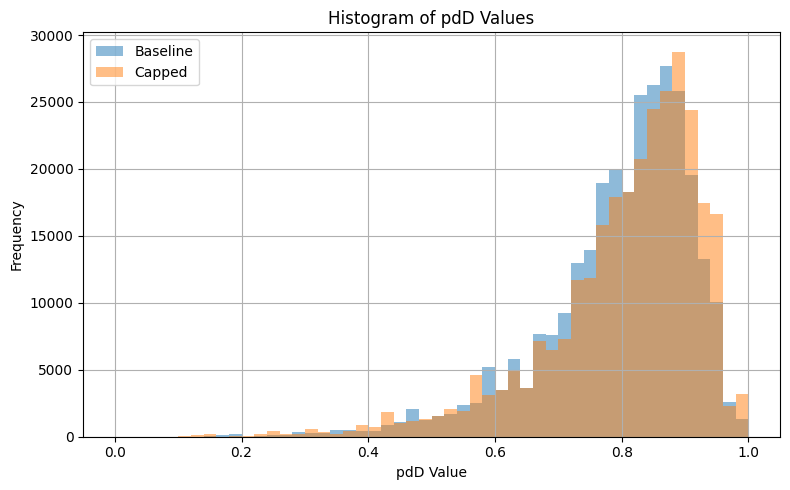

In [17]:
# overlayed
plt.figure(figsize=(8, 5))
plt.hist(pdD_baseline, bins=50, range=(0, 1), alpha=0.5, label='Baseline')
plt.hist(pdD_capped, bins=50, range=(0, 1), alpha=0.5, label='Capped')
plt.xlabel('pdD Value')
plt.ylabel('Frequency')
plt.title('Histogram of pdD Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

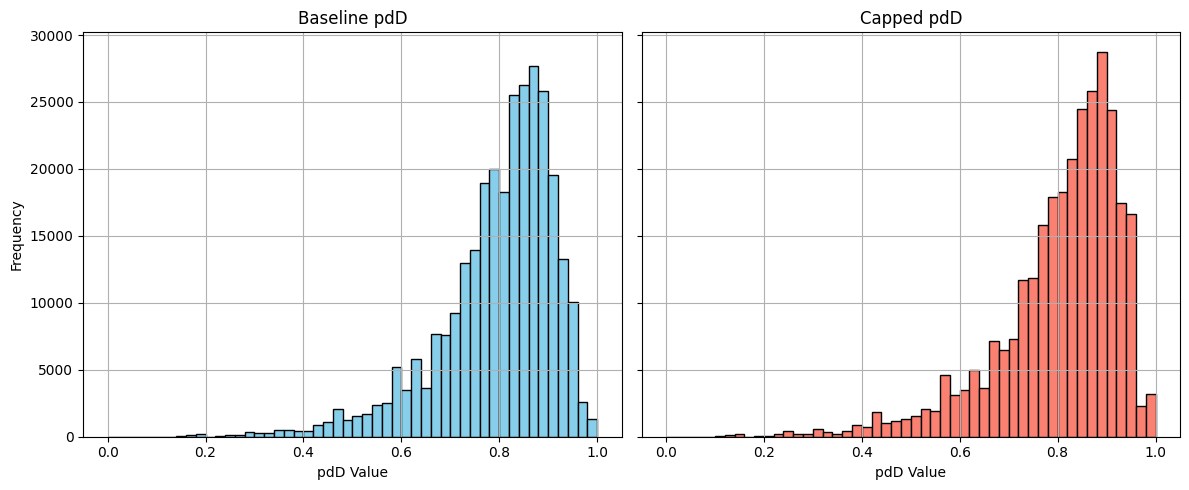

In [19]:
# side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# histogram for baseline
axs[0].hist(pdD_baseline, bins=50, range=(0, 1), color='skyblue', edgecolor='black')
axs[0].set_title('Baseline pdD')
axs[0].set_xlabel('pdD Value')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# histogram for capped
axs[1].hist(pdD_capped, bins=50, range=(0, 1), color='salmon', edgecolor='black')
axs[1].set_title('Capped pdD')
axs[1].set_xlabel('pdD Value')
axs[1].grid(True)

plt.tight_layout()
plt.show()